In [24]:
import kagglehub
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity

relogios = kagglehub.dataset_download("mathewkouch/a-dataset-of-watches")
guitarras = kagglehub.dataset_download("bedantsharma/guitar-images")
pizza = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")
tenis = kagglehub.dataset_download("olehsyniuk/sneakers-recognition-dataset-v22")

source_dirs = [
    "/root/.cache/kagglehub/datasets/mathewkouch/a-dataset-of-watches/versions/6/watches/watches/images",
    "/root/.cache/kagglehub/datasets/bedantsharma/guitar-images/versions/1/guitar_images",
    "/root/.cache/kagglehub/datasets/carlosrunner/pizza-not-pizza/versions/1/pizza_not_pizza/pizza",
    "/root/.cache/kagglehub/datasets/olehsyniuk/sneakers-recognition-dataset-v22/versions/1/Sneakers_Recognition_DataSet/NewBalance_10003"
]

destination_dir = "/content/datasets"
os.makedirs(destination_dir, exist_ok=True)

for source_dir in source_dirs:
    if os.path.exists(source_dir):
        dir_name = os.path.basename(source_dir)
        new_destination_path = os.path.join(destination_dir, dir_name)
        shutil.move(source_dir, new_destination_path)

Using Colab cache for faster access to the 'a-dataset-of-watches' dataset.
Using Colab cache for faster access to the 'guitar-images' dataset.
Using Colab cache for faster access to the 'pizza-not-pizza' dataset.
Using Colab cache for faster access to the 'sneakers-recognition-dataset-v22' dataset.


In [4]:
dataset_path = "/content/datasets"
exclude = ['.ipynb_checkpoints']

remove_dir = os.path.join(dataset_path, '.ipynb_checkpoints')
if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)

categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and d not in exclude]
print(categories)

img_height = 224
img_width = 224
batch_size = 32

image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_gen = image_generator.flow_from_directory(
    directory=dataset_path,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='training',
    class_mode='categorical'
)

val_data_gen = image_generator.flow_from_directory(
    directory=dataset_path,
    batch_size=batch_size,
    target_size=(img_height, img_width),
    subset='validation',
    class_mode='categorical'
)

num_classes = train_data_gen.num_classes
print(f"Number of classes: {num_classes}")

['relogio', 'pizza', 'guitarra', 'tenis']
Found 4541 images belonging to 4 classes.
Found 1132 images belonging to 4 classes.
Number of classes: 4


In [5]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
epochs = 5
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs
)
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_data_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8995 - loss: 0.3057 - val_accuracy: 0.9973 - val_loss: 0.0135
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9995 - loss: 0.0100 - val_accuracy: 0.9982 - val_loss: 0.0086
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9988 - loss: 0.0068 - val_accuracy: 0.9991 - val_loss: 0.0072
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9991 - val_loss: 0.0067
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9991 - val_loss: 0.0059
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9984 - loss: 0.0085
Validation Loss: 0.0059
Validation Accuracy: 0.9991


In [7]:
training_dataset_path = "/content/datasets"
diverse_images_path = "/content/diversas"

def load_and_preprocess_images(directory):
    images = []
    filenames = []

    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                try:
                    img = image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = image.img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)
                    img_array /= 255.0
                    images.append(img_array)
                    relative_path = os.path.relpath(img_path, directory)
                    filenames.append(relative_path)
                except Exception as e:
                    print(f"Could not process image {filename}: {e}")

    # Concatenate all image arrays into a single numpy array
    if images:
        images = np.vstack(images)
    return images, filenames


train_images, train_filenames = load_and_preprocess_images(training_dataset_path)
diverse_images, diverse_filenames = load_and_preprocess_images(diverse_images_path)

Loading and preprocessing training images...
Loaded 5673 training images.

Loading and preprocessing diverse images...
Loaded 37 diverse images.


In [8]:
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.output)

train_features = feature_extractor_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)

diverse_features = feature_extractor_model.predict(diverse_images)
diverse_features = diverse_features.reshape(diverse_features.shape[0], -1)

Extracting features from training images...
178/178 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step
Extracted features for 5673 training images with shape (5673, 62720).

Extracting features from diverse images...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step
Extracted features for 37 diverse images with shape (37, 62720).


Finding the most similar image from the diverse dataset for each training class:


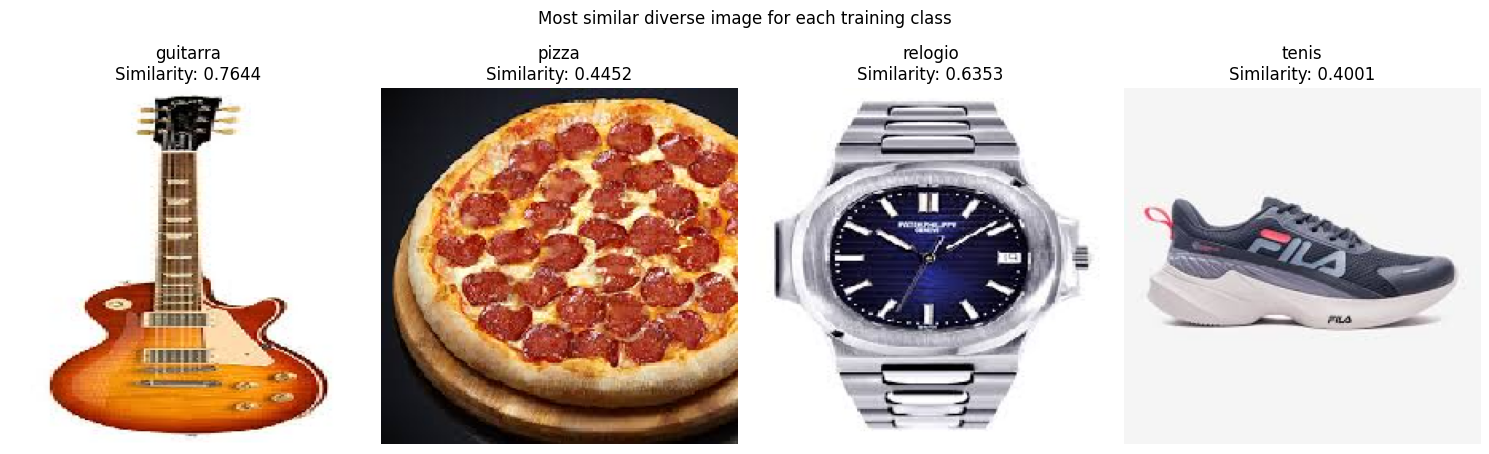

In [12]:

class_indices = train_data_gen.class_indices
# Create a mapping from index to class label
idx_to_class = {v: k for k, v in class_indices.items()}

similarity_matrix = cosine_similarity(diverse_features, train_features)

print("Finding the most similar image from the diverse dataset for each training class:")

num_classes = len(class_indices)
plt.figure(figsize=(15, 5))
plt.suptitle("Most similar diverse image for each training class")

displayed_classes = 0

for class_name, class_idx in class_indices.items():
    class_train_indices = [i for i, filename in enumerate(train_filenames) if filename.startswith(class_name + os.sep)]

    if not class_train_indices:
        print(f"No training images found for class: {class_name}")
        continue

    # Get the similarity scores between all diverse images and the training images of this class
    class_similarity_scores = similarity_matrix[:, class_train_indices]

    # For each diverse image, find its maximum similarity to any image within this class
    max_similarity_to_class = np.max(class_similarity_scores, axis=1)

    # Find the diverse image with the overall highest maximum similarity to this class
    most_similar_diverse_image_index = np.argmax(max_similarity_to_class)
    highest_similarity_score = max_similarity_to_class[most_similar_diverse_image_index]

    # Display the most similar diverse image for this class
    if most_similar_diverse_image_index < len(diverse_filenames):
        img_path = os.path.join("/content/diversas", diverse_filenames[most_similar_diverse_image_index])
        if os.path.exists(img_path):
            try:
                img = image.load_img(img_path, target_size=(img_height, img_width))
                plt.subplot(1, num_classes, displayed_classes + 1)
                plt.imshow(img)
                plt.title(f"{class_name}\nSimilarity: {highest_similarity_score:.4f}")
                plt.axis('off')
                displayed_classes += 1
            except Exception as e:
                print(f"Could not process image {diverse_filenames[most_similar_diverse_image_index]}: {e}")

plt.tight_layout()
plt.show()